# MobileFaceNet for Face Dectection 

The tutorial will demonstrate how to step by step achieve face recognition using MTCNN and MobileFaceNet. The pipeline is illustrated below. MTCNN is utilized to detect the face and facial landmarks. The face image is then cropped based on the bounding box and resized as 112x112 in this case. Face alignment algorithm is applied to transform the face image such that the landmarks on the input face match the designated (pre-defined) landmarks. The facenet model is then imposed to extract face features. The determination of face matching will be based on their features' similarity or distance.  

<img src="images/ipy_pic/pipeline.png"  width="700" style="float: left;">

[The Mobilefacenet](https://arxiv.org/pdf/1804.07573.pdf) is introduced to allow extreme computational efficiency with superior accuracy after careful design of the architecture. This efficient CNN model is well tailored for high-accuracy real-time face verification on mobile and embedded devices. The MobileFaceNet architecture can be found from the paper. 

Now let's get started and build up our own face recognition system. The training process and accuracy evaluation can be found from "MobileFaceNet_Training_Step_by_Step.ipynb" 

## Code

In [1]:
import sys
import os
sys.path.append('MTCNN')
import argparse
import torch
from torchvision import transforms as trans
from PIL import Image, ImageDraw, ImageFont
from utils.util import *
from utils.align_trans import *
from MTCNN import create_mtcnn_net
from face_model import MobileFaceNet, l2_norm
from facebank import load_facebank, prepare_facebank
import cv2
import time
from pathlib import Path
import matplotlib.pyplot as plt

The MobileFaceNet model is loaded with well trained weights using Pytorch. In this work, we encode a 512 feature vector for face matching 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

detect_model = MobileFaceNet(512).to(device)  # embeding size is 512 (feature vector)
detect_model.load_state_dict(torch.load('Weights/MobileFace_Net', map_location=lambda storage, loc: storage))
print('MobileFaceNet face detection model generated')
detect_model.eval()

MobileFaceNet face detection model generated


MobileFaceNet(
  (conv1): Conv_block(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv2_dw): Conv_block(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=64)
  )
  (conv_23): Depth_Wise(
    (conv): Conv_block(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=128)
    )
    (conv_dw): Conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

"prepare_facebank" function is designed to generate the face feature database 'facebank.pth' and corresponding namelist 'names.npy'. In this repo, a demo facebank folder is built with the major characters from the sitcom 'The Big Bang Theory'. Each folder contains a person's pictures with the his/her name as the folder name. This function will extract the feature vector and build up a database. If more than one picture exist in a folder. The feature vector will be encoded as average. 

In [3]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

def prepare_facebank(model, path = 'facebank', tta = True):
    model.eval()
    embeddings = []
    names = ['']
    data_path = Path(path)

    for doc in data_path.iterdir():

        if doc.is_file():
            continue
        else:
            embs = []
            for files in listdir_nohidden(doc):
                image_path = os.path.join(doc, files)
                img = cv2.imread(image_path)

                if img.shape != (112, 112, 3):
                    bboxes, landmarks = create_mtcnn_net(img, 20, device,
                                                     p_model_path='MTCNN/weights/pnet_Weights',
                                                     r_model_path='MTCNN/weights/rnet_Weights',
                                                     o_model_path='MTCNN/weights/onet_Weights')

                    img = Face_alignment(img, default_square=True, landmarks=landmarks)

                with torch.no_grad():
                    if tta:
                        mirror = cv2.flip(img, 1)
                        emb = model(test_transform(img).to(device).unsqueeze(0))
                        emb_mirror = model(test_transform(mirror).to(device).unsqueeze(0))
                        embs.append(l2_norm(emb + emb_mirror))
                    else:
                        embs.append(model(test_transform(img).to(device).unsqueeze(0)))

            if len(embs) == 0:
                continue
            embedding = torch.cat(embs).mean(0, keepdim=True)
            embeddings.append(embedding)
            names.append(doc.name)

    embeddings = torch.cat(embeddings)
    names = np.array(names)
    torch.save(embeddings, os.path.join(path, 'facebank.pth'))
    np.save(os.path.join(path, 'names'), names)

    return embeddings, names

"test_transform" is to preprocess the input image for net. As a demo below, the facebank is created with associated namelist. It is noted that the names[0] is assiged as ' ' as we want to label empty if the input face is not matched to any feature vector from database. 

In [4]:
test_transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

targets, names = prepare_facebank(detect_model, path='facebank', tta=True)
print(targets.shape)
print(names)

torch.Size([6, 512])
['' 'Howard' 'Leonard' 'Linh' 'Penny' 'Raj' 'Sheldon']


Build up a visalize function to show the image 

In [5]:
def visalize(img, bboxes, landmarks, results):

    image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('utils/simkai.ttf', 40)
    for i, b in enumerate(bboxes):
        draw.rectangle([(b[0], b[1]), (b[2], b[3])], outline='blue', width=5)
        draw.text((int(b[0]), int(b[1]-25)), names[results[i] + 1], fill=(255,255,0), font=font)

    for p in landmarks:
        for i in range(5):
            draw.ellipse([(p[i] - 2.0, p[i + 5] - 2.0), (p[i] + 2.0, p[i + 5] + 2.0)], outline='red')

    image_ = np.array(image)
    plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
    plt.imshow(image_)

Use MTCNN to detect the face and landmarks

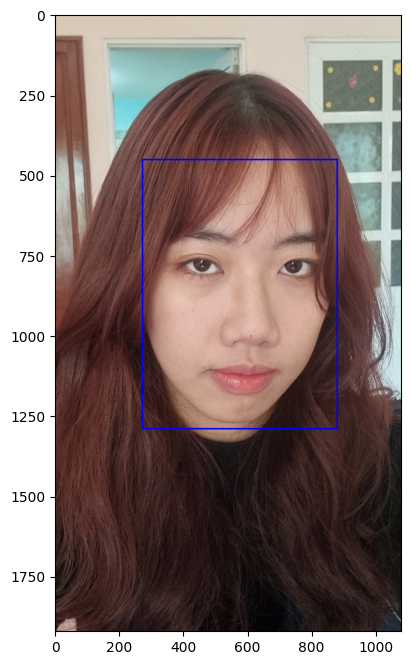

In [6]:
image = cv2.imread('images/Linh.jpg')
bboxes, landmarks = create_mtcnn_net(image, 32, device, p_model_path='MTCNN/weights/pnet_Weights',
                                         r_model_path='MTCNN/weights/rnet_Weights',
                                         o_model_path='MTCNN/weights/onet_Weights')
results = [-1 for i in range(len(bboxes))]
visalize(image, bboxes, landmarks, results)

We use cv2.warpAffine function to align the face to pre-defined 5 landmarks. 'transformation_from_points' is to find the transformation matrix. 'Face_alignment' is to output the cropped and aligned faces as a list  

In [7]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return np.vstack([np.hstack(((s2 / s1) * R, c2.T - (s2 / s1) * R * c1.T)), np.matrix([0., 0., 1.])])

def Face_alignment(img,landmarks = []):
    # face alignment -- similarity transformation
    faces = []
    if landmarks != []:
        for i in range(landmarks.shape[0]):
            landmark = landmarks[i, :]
            landmark = landmark.reshape(2, 5).T

            coord5point =  [[38.29459953, 51.69630051],
                            [73.53179932, 51.50139999],
                            [56.02519989, 71.73660278],
                            [41.54930115, 92.3655014 ],
                            [70.72990036, 92.20410156]]

            pts1 = np.float64(np.matrix([[point[0], point[1]] for point in landmark]))
            pts2 = np.float64(np.matrix([[point[0], point[1]] for point in coord5point]))
            M = transformation_from_points(pts1, pts2)
            aligned_image = cv2.warpAffine(img, M[:2], (img.shape[1], img.shape[0]))
            crop_img = aligned_image[0:112, 0:112]
            faces.append(crop_img)

    return faces

C:\Users\NgocLinh\AppData\Local\Temp\ipykernel_9936\1734871414.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if landmarks != []:


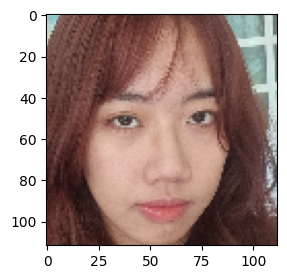

In [8]:
faces = Face_alignment(image,landmarks = landmarks)
face1 = faces[0]
plt.rcParams['figure.figsize'] = (5.0, 3.0) 
plt.imshow(face1[:,:,::-1])

Extract the feature vector matrix from cropped and aligned faces. The face can be flipped to encode the feature vector but with sacifice of inference time. the 'source_embs' is extracted as a shape [n, 512]. n denotes the number of faces 

In [9]:
embs = []
for img in faces:
    mirror = cv2.flip(img,1)
    emb = detect_model(test_transform(img).to(device).unsqueeze(0))
    emb_mirror = detect_model(test_transform(mirror).to(device).unsqueeze(0))
    embs.append(l2_norm(emb + emb_mirror))
source_embs = torch.cat(embs)  # number of detected faces x 512
source_embs.shape

torch.Size([1, 512])

The face matching here uses L2 distance between source and database. If the minimum distance between "source_embs" and database "targets" is lower than pre-defined threshold, the corresponding name label will be assigned, otherwise set the label as empty.

In [10]:
threshold = 1.2
diff = source_embs.unsqueeze(-1) - targets.transpose(1, 0).unsqueeze(0) # i.e. 3 x 512 x 1 - 1 x 512 x 2 = 3 x 512 x 2
dist = torch.sum(torch.pow(diff, 2), dim=1) # number of detected faces x numer of target faces
minimum, min_idx = torch.min(dist, dim=1) # min and idx for each row
min_idx[minimum > threshold] = -1  # if no match, set idx to -1
score = minimum
results = min_idx

results

tensor([2])

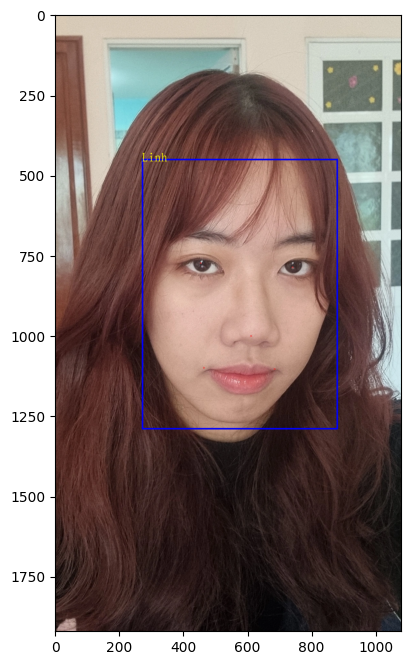

In [11]:
visalize(image, bboxes, landmarks, results)

## End